In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train_data=pd.read_csv('data/train.csv')
test_df=pd.read_csv('data/test.csv')
train_df=train_data[train_data.loc[:,'Time']<3]
val_df=train_data[train_data.loc[:,'Time']==3]

del train_data

## baseline
以默认参数的XGB分数为准，低于此基准线2.554的模型一律不考虑。

In [32]:
def xgb_eval(train_df,val_df):
    train_df=train_df.copy()
    val_df=val_df.copy()

    try:
        from sklearn.preprocessing import LabelEncoder
        lb_encoder=LabelEncoder()
        lb_encoder.fit(train_df.loc[:,'RoomDir'].append(val_df.loc[:,'RoomDir']))
        train_df.loc[:,'RoomDir']=lb_encoder.transform(train_df.loc[:,'RoomDir'])
        val_df.loc[:,'RoomDir']=lb_encoder.transform(val_df.loc[:,'RoomDir'])
    except Exception as e:
        print(e)

    import xgboost as xgb
    X_train=train_df.drop(['Rental'],axis=1)
    Y_train=train_df.loc[:,'Rental'].values
    X_val=val_df.drop(['Rental'],axis=1)
    Y_val=val_df.loc[:,'Rental'].values

    from sklearn.metrics import mean_squared_error

    try:
        eval_df=val_df.copy().drop('Time',axis=1)
    except Exception as e:
        eval_df=val_df.copy()

    reg_model=xgb.XGBRegressor(max_depth=5,n_estimators=500,n_jobs=-1)
    reg_model.fit(X_train,Y_train)

    y_pred=reg_model.predict(X_val)
    print(np.sqrt(mean_squared_error(Y_val,y_pred)),end=' ')

    eval_df.loc[:,'Y_pred']=y_pred
    eval_df.loc[:,'RE']=eval_df.loc[:,'Y_pred']-eval_df.loc[:,'Rental']
    
    print('')
    feature=X_train.columns
    fe_im=reg_model.feature_importances_
    print(pd.DataFrame({'fe':feature,'im':fe_im}).sort_values(by='im',ascending=False))

    import matplotlib.pyplot as plt
    plt.clf()
    plt.figure(figsize=(15,4))
    plt.plot([Y_train.min(),Y_train.max()],[0,0],color='red')
    plt.scatter(x=eval_df.loc[:,'Rental'],y=eval_df.loc[:,'RE'])
    plt.show()

    return eval_df

In [ ]:
# # 默认RMSE为2.55426
# eval_df=xgb_eval(train_df,val_df)
# eval_df.to_csv('org_eval.csv',index=False)

## 原生特征的丢弃尝试
以XGB做原生特征筛选，在原生特征中丢弃后不影响分数甚至涨分的特征有：Time，**RentRoom**(涨幅明显)，RoomDir，**Livingroom**，**RentType**(涨幅明显)，**SubwayLine**(涨幅明显)，**SubwayDis**(涨幅明显)。

In [ ]:
# # 丢弃各特征后的分数
# # ‘Time':2.558,'Neighborhood':2.592,'RentRoom':2.531,'Height':2.57,'TolHeight':2.591,'RoomArea':3
# # 'RoomDir':2.548,'RentStatus':2.561,'Bedroom':2.584,'Livingroom':2.548,'Bathroom':2.590,'RentType':2.538
# # 'Region':2.583,'BusLoc':2.594,'SubwayLine':2.521,'SubwaySta':2.569,'SubwayDis':2.537,'RemodCond':2.571
# for col in train_df.columns:
#     if col!='Rental':
#         print('drop col:{}'.format(col))
#         tmp_train_df=train_df.drop([col],axis=1)
#         tmp_val_df=val_df.drop([col],axis=1)
#         eval_df=xgb_eval(train_df=tmp_train_df,val_df=tmp_val_df)

# # 一起丢弃:2.553
# tmp_train_df=train_df.copy()
# tmp_val_df=val_df.copy()
# tmp_train_df.drop(['Time','RentRoom','RoomDir','Livingroom','RentType','SubwayLine','SubwayDis'],axis=1,inplace=True)
# tmp_val_df.drop(['Time','RentRoom','RoomDir','Livingroom','RentType','SubwayLine','SubwayDis'],axis=1,inplace=True)
# eval_df=xgb_eval(train_df=tmp_train_df,val_df=tmp_val_df)

## 特征工程
这里并未包含我们尝试过的所有特征，有些代码删掉了。

In [ ]:
# # 朝向特征取首次出现的朝向，此种处理方式的可视化结果与[南、东南、东、西南、北、西]的事实相符
# # 得分2.548
# def ex_dir(direction):
#     try:
#         direction=direction.split(' ')[0]
#     except Exception as e:
#         pass
#     return direction

# tmp_train_df=train_df.copy()
# tmp_val_df=val_df.copy()
# tmp_train_df.loc[:,'RoomDir']=train_df.loc[:,'RoomDir'].apply(ex_dir)
# tmp_val_df.loc[:,'RoomDir']=val_df.loc[:,'RoomDir'].apply(ex_dir)

# eval_df=xgb_eval(train_df=tmp_train_df,val_df=tmp_val_df)

# # 朝向rank-encoding:2.550
# rank_df=tmp_train_df.loc[:,['RoomDir','Rental']].groupby('RoomDir',as_index=False).mean().sort_values(by='Rental').reset_index(drop=True)
# rank_df.loc[:,'RoomDir'+'_rank']=rank_df.index+1
# rank_fe_df=rank_df.drop(['Rental'],axis=1)
# tmp_train_df=tmp_train_df.merge(rank_fe_df,how='left',on='RoomDir')
# tmp_val_df=tmp_val_df.merge(rank_fe_df,how='left',on='RoomDir')
# tmp_train_df.drop(['RoomDir'],axis=1,inplace=True)
# tmp_val_df.drop(['RoomDir'],axis=1,inplace=True)

# eval_df=xgb_eval(train_df=tmp_train_df,val_df=tmp_val_df)

In [ ]:
# # 总房间数TolRooms:2.506
# tmp_train_df=train_df.copy()
# tmp_val_df=val_df.copy()
# tmp_train_df.loc[:,'TolRooms']=tmp_train_df.loc[:,'Livingroom']+tmp_train_df.loc[:,'Bedroom']+tmp_train_df.loc[:,'Bathroom']
# tmp_val_df.loc[:,'TolRooms']=tmp_val_df.loc[:,'Livingroom']+tmp_val_df.loc[:,'Bedroom']+tmp_val_df.loc[:,'Bathroom']
# eval_df=xgb_eval(train_df=tmp_train_df,val_df=tmp_val_df)

# # 再加上平均面积:2.515
# tmp_train_df.loc[:,'Area/Room']=tmp_train_df.loc[:,'RoomArea']/(tmp_train_df.loc[:,'TolRooms']+1)
# tmp_val_df.loc[:,'Area/Room']=tmp_val_df.loc[:,'RoomArea']/(tmp_val_df.loc[:,'TolRooms']+1)
# eval_df=xgb_eval(train_df=tmp_train_df,val_df=tmp_val_df)

In [ ]:
# 领域知识特征：卧室面积占1/3，卫生间面积占1/14，客厅占1/3，单调变换对树模型无用，使用卧室(卫生间)平均面积
# 掉分厉害，弃用
# tmp_train_df=train_df.copy()
# tmp_val_df=val_df.copy().

# tmp_train_df.loc[:,'Area/Bedroom']=tmp_train_df.loc[:,'RoomArea']/tmp_train_df.loc[:,'Bedroom']
# tmp_val_df.loc[:,'Area/Bedroom']=tmp_val_df.loc[:,'RoomArea']/tmp_train_df.loc[:,'Bedroom']
# tmp_train_df.loc[:,'Area/Bathroom']=tmp_train_df.loc[:,'RoomArea']/tmp_train_df.loc[:,'Bathroom']
# tmp_val_df.loc[:,'Area/Bathroom']=tmp_val_df.loc[:,'RoomArea']/tmp_train_df.loc[:,'Bathroom']
# tmp_train_df.loc[:,'Area/Livingroom']=tmp_train_df.loc[:,'RoomArea']/tmp_train_df.loc[:,'Livingroom']
# tmp_val_df.loc[:,'Area/Livingroom']=tmp_val_df.loc[:,'RoomArea']/tmp_train_df.loc[:,'Livingroom']
# tmp_train_df.loc[:,'OtherArea']=tmp_train_df.loc[:,'RoomArea']-tmp_train_df.loc[:,'Area/Bedroom']-tmp_train_df.loc[:,'Area/Bathroom']-tmp_train_df.loc[:,'Area/Livingroom']
# tmp_val_df.loc[:,'OtherArea']=tmp_val_df.loc[:,'RoomArea']-tmp_val_df.loc[:,'Area/Bedroom']-tmp_val_df.loc[:,'Area/Bathroom']-tmp_val_df.loc[:,'Area/Livingroom']
# eval_df=xgb_eval(train_df=tmp_train_df,val_df=tmp_val_df)

In [ ]:
# # 楼层出租屋总面积，未尝试
# tmp_train_df=train_df.copy()
# tmp_val_df=val_df.copy()

# total_area_train=tmp_train_df.groupbypby([''])

In [ ]:
# # 以X室X厅制作一个户型特征:2.546
# tmp_train_df=train_df.copy()
# tmp_val_df=val_df.copy()
# tmp_train_df.loc[:,'RoomStr']=tmp_train_df.loc[:,'Bedroom']+tmp_train_df.loc[:,'Livingroom']
# tmp_val_df.loc[:,'RoomStr']=tmp_val_df.loc[:,'Bedroom']+tmp_val_df.loc[:,'Livingroom']
# eval_df=xgb_eval(train_df=tmp_train_df,val_df=tmp_val_df)

In [ ]:
# # 以相对高度Height除以相对总高度TolHeight得到一个绝对高度ab_Height
# # 得分：2.561
# tmp_train_df=train_df.copy()
# tmp_val_df=val_df.copy()

# tmp_train_df.loc[:,'ab_Height']=tmp_train_df.loc[:,'Height']/(tmp_train_df.loc[:,'TolHeight']+1)
# tmp_val_df.loc[:,'ab_Height']=tmp_val_df.loc[:,'Height']/(tmp_val_df.loc[:,'TolHeight']+1)

# eval_df=xgb_eval(train_df=tmp_train_df,val_df=tmp_val_df)

In [ ]:
# # 出租房的数目除以楼层总高度，计算该栋楼的出租率
# # 得分：2.595
# tmp_train_df=train_df.copy()
# tmp_val_df=val_df.copy()

# tmp_train_df.loc[:,'Rent_pct']=tmp_train_df.loc[:,'RentRoom']/((tmp_train_df.loc[:,'TolHeight']+1))
# tmp_val_df.loc[:,'Rent_pct']=tmp_val_df.loc[:,'RentRoom']/((tmp_val_df.loc[:,'TolHeight']+1))

# eval_df=xgb_eval(train_df=tmp_train_df,val_df=tmp_val_df)

In [ ]:
# 猜想：能不能用数据分析推算出每间出租房所在小区的单元？？？
# 小区已知，但小区里面有很多单元，能不能推算出单元？？？
# 这是个类别特征，而且类别数应该会很多，比小区数还多


In [ ]:
# # 地铁特征，房子是否有'近地铁'这个属性:重要性为0
# tmp_train_df=train_df.copy()
# tmp_val_df=val_df.copy()
# tmp_train_df.loc[:,'NearSubway']=(~tmp_train_df.loc[:,'SubwayLine'].isnull()).astype(np.int8).values
# tmp_val_df.loc[:,'NearSubway']=(~tmp_val_df.loc[:,'SubwayLine'].isnull()).astype(np.int8).values

# eval_df=xgb_eval(train_df=tmp_train_df,val_df=tmp_val_df)

In [ ]:
# 数据中有关于地铁的距离特征，这个怎么用？能不能利用这个地理信息进行聚类或rank


In [ ]:
# # 根据有序特征进行聚类，构造无监督特征
# # eps=0.1，不编码原聚类特征
# # 得分：2.544
# cls_cols=['Height','TolHeight','RoomArea','Bedroom','Livingroom','Bathroom']        # 聚类列
# all_cols=cls_cols+['Rental']

# tmp_train_df=train_df.copy()
# tmp_val_df=val_df.copy()
# need_scale=tmp_train_df.loc[:,cls_cols].append(tmp_val_df.loc[:,cls_cols])

# from sklearn.preprocessing import MinMaxScaler
# mm_scaler=MinMaxScaler()
# need_scale=mm_scaler.fit_transform(need_scale)

# from sklearn.cluster import DBSCAN
# cls_model=DBSCAN(eps=0.1, min_samples=3,n_jobs=-1).fit(need_scale)

# tmp_train_df.loc[:,'clsFe']=cls_model.labels_[:len(tmp_train_df)]
# tmp_val_df.loc[:,'clsFe']=cls_model.labels_[len(tmp_train_df):]

# eval_df=xgb_eval(train_df=tmp_train_df,val_df=tmp_val_df)

In [ ]:
# # 统计特征如计数值，区间等等，未尝试
# cat_cols=['Neighborhood','Height','TolHeight','RoomDir','']

In [ ]:
# # rank_encoding(mean_encoding)
# # 使用循环对所有列遍历做编码。两种编码方式类似，只是一个是离散特征，一个是连续特征，后者容易过拟合。

# # 以平均租金为准添加评级特征，部分有用
# # 'Time':2.554,'Height':2.549,'TolHeight'2.545
# # 'Bedroom':2.546,'Livingroom':2.550,'Bathroom':2.551,'RentType':2.554
# # 'Region':2.491,'BusLoc':2.480,'SubwayLine':2.539,'SubwaySta':'2.518','RemodCond':2.543
# rank_cols=['Time','Height','TolHeight','Bedroom','Livingroom','Bathroom',
#            'RentType','Region','BusLoc','SubwayLine','SubwaySta','RemodCond']
# for col in rank_cols:
#     if col!='Rental':
#         print(col+'_rank_encoding...')
#         tmp_train_df=train_df.copy()
#         tmp_val_df=val_df.copy()

#         rank_df=train_df.loc[:,[col,'Rental']].groupby(col,as_index=False).mean().sort_values(by='Rental').reset_index(drop=True)
#         rank_df.loc[:,col+'_rank']=rank_df.index+1        # +1，为缺失值预留一个0值的rank
#         rank_fe_df=rank_df.drop(['Rental'],axis=1)
#         tmp_train_df=tmp_train_df.merge(rank_fe_df,how='left',on=col)
#         tmp_val_df=tmp_val_df.merge(rank_fe_df,how='left',on=col)
#         tmp_train_df.drop([col],axis=1,inplace=True)
#         tmp_val_df.drop([col],axis=1,inplace=True)

#         eval_df=xgb_eval(train_df=tmp_train_df,val_df=tmp_val_df)

## 特征选择
一股脑加上所有特征表现不佳，使用贪心策略(前向选择、后向选择)逐个添加特征。

In [ ]:
# train_data=pd.read_csv('train.csv')
# train_df=train_data[train_data.loc[:,'Time']<3]
# val_df=train_data[train_data.loc[:,'Time']==3]

# drop_cols=['SubwayLine','RentRoom','Time']        # 需要丢弃的原生特征

# comb_train_df=train_df.copy()
# comb_val_df=val_df.copy()

# # 前向特征选择这块我是用for循环暴力搜出来的最优特征组合，最终筛选出来的特征组合为：
# # ['ab_Height','TolRooms','Area/Room','BusLoc_rank','SubwayLine_rank']

# comb_train_df.loc[:,'ab_Height']=comb_train_df.loc[:,'Height']/(comb_train_df.loc[:,'TolHeight']+1)
# comb_val_df.loc[:,'ab_Height']=comb_val_df.loc[:,'Height']/(comb_val_df.loc[:,'TolHeight']+1)

# comb_train_df.loc[:,'TolRooms']=comb_train_df.loc[:,'Livingroom']+comb_train_df.loc[:,'Bedroom']+comb_train_df.loc[:,'Bathroom']
# comb_val_df.loc[:,'TolRooms']=comb_val_df.loc[:,'Livingroom']+comb_val_df.loc[:,'Bedroom']+comb_val_df.loc[:,'Bathroom']
# comb_train_df.loc[:,'Area/Room']=comb_train_df.loc[:,'RoomArea']/(comb_train_df.loc[:,'TolRooms']+1)
# comb_val_df.loc[:,'Area/Room']=comb_val_df.loc[:,'RoomArea']/(comb_val_df.loc[:,'TolRooms']+1)

# rank_cols=['BusLoc','SubwayLine']
# for col in rank_cols:
#     rank_df=train_df.loc[:,[col,'Rental']].groupby(col,as_index=False).mean().sort_values(by='Rental').reset_index(drop=True)
#     rank_df.loc[:,col+'_rank']=rank_df.index+1        # +1，为缺失值预留一个0值的rank
#     rank_fe_df=rank_df.drop(['Rental'],axis=1)
#     comb_train_df=comb_train_df.merge(rank_fe_df,how='left',on=col)
#     comb_val_df=comb_val_df.merge(rank_fe_df,how='left',on=col)
#     try:
#         comb_train_df.drop([col],axis=1,inplace=True)
#         comb_val_df.drop([col],axis=1,inplace=True)
#     except Exception as e:
#         print(e)
# for drop_col in drop_cols:
#         try:
#             comb_train_df.drop(drop_col,axis=1,inplace=True)
#             comb_val_df.drop(drop_col,axis=1,inplace=True)
#         except Exception as e:
#             pass

# # 贪心策略添加特征，目前为:2.403
# eval_df=xgb_eval(train_df=comb_train_df,val_df=comb_val_df)

## 调优

[0]	validation_0-rmse:8.78249
Will train until validation_0-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:2.36576
[200]	validation_0-rmse:2.23093
[300]	validation_0-rmse:2.1509
[400]	validation_0-rmse:2.08998
[500]	validation_0-rmse:2.05739
[600]	validation_0-rmse:2.03298
[700]	validation_0-rmse:2.0145
[800]	validation_0-rmse:2.00196
[900]	validation_0-rmse:1.99024
[1000]	validation_0-rmse:1.98088
[1100]	validation_0-rmse:1.97277
Stopping. Best iteration:
[1168]	validation_0-rmse:1.96779

1.9677954303629377 
                 fe        im
3          RoomArea  0.176308
0      Neighborhood  0.151993
16        Area/Room  0.146165
4           RoomDir  0.083905
2         TolHeight  0.073936
12        SubwayDis  0.068511
17      BusLoc_rank  0.055537
14        ab_Height  0.051043
1            Height  0.039684
11        SubwaySta  0.034333
10           Region  0.027275
6           Bedroom  0.018188
15         TolRooms  0.014438
7        Livingroom  0.014165
5        RentStatus  0.

<Figure size 432x288 with 0 Axes>

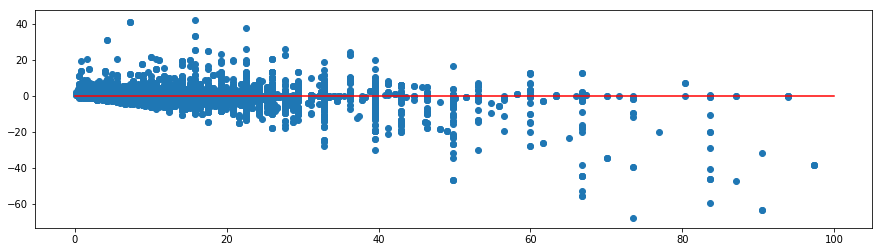

In [33]:
def xgb_eval(train_df,val_df):
    train_df=train_df.copy()
    val_df=val_df.copy()

    try:
        from sklearn.preprocessing import LabelEncoder
        lb_encoder=LabelEncoder()
        lb_encoder.fit(train_df.loc[:,'RoomDir'].append(val_df.loc[:,'RoomDir']))
        train_df.loc[:,'RoomDir']=lb_encoder.transform(train_df.loc[:,'RoomDir'])
        val_df.loc[:,'RoomDir']=lb_encoder.transform(val_df.loc[:,'RoomDir'])
    except Exception as e:
        print(e)

    import xgboost as xgb
    X_train=train_df.drop(['Rental'],axis=1)
    Y_train=train_df.loc[:,'Rental'].values
    X_val=val_df.drop(['Rental'],axis=1)
    Y_val=val_df.loc[:,'Rental'].values

    from sklearn.metrics import mean_squared_error

    try:
        eval_df=val_df.copy().drop('Time',axis=1)
    except Exception as e:
        eval_df=val_df.copy()

    reg_model=xgb.XGBRegressor(max_depth=8,n_estimators=99999,learning_rate=0.1,
                               reg_alpha=0.5,reg_lambda=0.5,n_jobs=-1)
    reg_model.fit(X_train,Y_train,eval_set=[(X_val,Y_val)],verbose=100,early_stopping_rounds=10)

    y_pred=reg_model.predict(X_val)
    print(np.sqrt(mean_squared_error(Y_val,y_pred)),end=' ')

    eval_df.loc[:,'Y_pred']=y_pred
    eval_df.loc[:,'RE']=eval_df.loc[:,'Y_pred']-eval_df.loc[:,'Rental']

    print('')
    feature=X_train.columns
    fe_im=reg_model.feature_importances_
    print(pd.DataFrame({'fe':feature,'im':fe_im}).sort_values(by='im',ascending=False))

    import matplotlib.pyplot as plt
    plt.clf()
    plt.figure(figsize=(15,4))
    plt.plot([Y_train.min(),Y_train.max()],[0,0],color='red')
    plt.scatter(x=eval_df.loc[:,'Rental'],y=eval_df.loc[:,'RE'])
    plt.show()

    return eval_df

# 调参记录
# dep8
#     est1000:1.985,
#     est1880:1.943,1.94
#     earning_rate=0.05,est2643:1.9446
#     earning_rate=0.03,est4237:1.975
#     reg_alpha0.5,reg_lambda0.5,est1597:1.945
#         earning_rate=0.05,est2245:1.947
#     min_child_weight2,est1070:1.97


train_data=pd.read_csv('train.csv')
train_df=train_data[train_data.loc[:,'Time']<3]
val_df=train_data[train_data.loc[:,'Time']==3]

drop_cols=['SubwayLine','RentRoom','Time']

comb_train_df=train_df.copy()
comb_val_df=val_df.copy()

comb_train_df.loc[:,'ab_Height']=comb_train_df.loc[:,'Height']/(comb_train_df.loc[:,'TolHeight']+1)
comb_val_df.loc[:,'ab_Height']=comb_val_df.loc[:,'Height']/(comb_val_df.loc[:,'TolHeight']+1)

comb_train_df.loc[:,'TolRooms']=comb_train_df.loc[:,'Livingroom']+comb_train_df.loc[:,'Bedroom']+comb_train_df.loc[:,'Bathroom']
comb_val_df.loc[:,'TolRooms']=comb_val_df.loc[:,'Livingroom']+comb_val_df.loc[:,'Bedroom']+comb_val_df.loc[:,'Bathroom']
comb_train_df.loc[:,'Area/Room']=comb_train_df.loc[:,'RoomArea']/(comb_train_df.loc[:,'TolRooms']+1)
comb_val_df.loc[:,'Area/Room']=comb_val_df.loc[:,'RoomArea']/(comb_val_df.loc[:,'TolRooms']+1)

rank_cols=['BusLoc','SubwayLine']
for col in rank_cols:
    rank_df=train_df.loc[:,[col,'Rental']].groupby(col,as_index=False).mean().sort_values(by='Rental').reset_index(drop=True)
    rank_df.loc[:,col+'_rank']=rank_df.index+1        # +1，为缺失值预留一个0值的rank
    rank_fe_df=rank_df.drop(['Rental'],axis=1)
    comb_train_df=comb_train_df.merge(rank_fe_df,how='left',on=col)
    comb_val_df=comb_val_df.merge(rank_fe_df,how='left',on=col)
    try:
        comb_train_df.drop([col],axis=1,inplace=True)
        comb_val_df.drop([col],axis=1,inplace=True)
    except Exception as e:
        print(e)
for drop_col in drop_cols:
        try:
            comb_train_df.drop(drop_col,axis=1,inplace=True)
            comb_val_df.drop(drop_col,axis=1,inplace=True)
        except Exception as e:
            pass

eval_df=xgb_eval(train_df=comb_train_df,val_df=comb_val_df)

In [ ]:
# # 后向特征选择，虽然后向特征选择在未调参时比前向选择要好，但是调参之后的分数不如前向选择
# # 所以这一部分弃用了，实际上可以将这两个模型结合起来的，这里是一个上分点，我懒得尝试了

# def xgb_eval(train_df,val_df):
#     train_df=train_df.copy()
#     val_df=val_df.copy()

#     try:
#         from sklearn.preprocessing import LabelEncoder
#         lb_encoder=LabelEncoder()
#         lb_encoder.fit(train_df.loc[:,'RoomDir'].append(val_df.loc[:,'RoomDir']))
#         train_df.loc[:,'RoomDir']=lb_encoder.transform(train_df.loc[:,'RoomDir'])
#         val_df.loc[:,'RoomDir']=lb_encoder.transform(val_df.loc[:,'RoomDir'])
#     except Exception as e:
#         print(e)

#     import xgboost as xgb
#     X_train=train_df.drop(['Rental'],axis=1)
#     Y_train=train_df.loc[:,'Rental'].values
#     X_val=val_df.drop(['Rental'],axis=1)
#     Y_val=val_df.loc[:,'Rental'].values

#     from sklearn.metrics import mean_squared_error

#     try:
#         eval_df=val_df.copy().drop('Time',axis=1)
#     except Exception as e:
#         eval_df=val_df.copy()

#     reg_model=xgb.XGBRegressor(max_depth=7,n_estimators=9999,n_jobs=-1)
#     reg_model.fit(X_train,Y_train,eval_set=[(X_val,Y_val)],verbose=100,early_stopping_rounds=10)

#     y_pred=reg_model.predict(X_val)
#     print(np.sqrt(mean_squared_error(Y_val,y_pred)),end=' ')

#     eval_df.loc[:,'Y_pred']=y_pred
#     eval_df.loc[:,'RE']=eval_df.loc[:,'Y_pred']-eval_df.loc[:,'Rental']
    
#     print('')
#     feature=X_train.columns
#     fe_im=reg_model.feature_importances_
#     print(pd.DataFrame({'fe':feature,'im':fe_im}).sort_values(by='im',ascending=False))

#     import matplotlib.pyplot as plt
#     plt.clf()
#     plt.figure(figsize=(15,4))
#     plt.plot([Y_train.min(),Y_train.max()],[0,0],color='red')
#     plt.scatter(x=eval_df.loc[:,'Rental'],y=eval_df.loc[:,'RE'])
#     plt.show()

#     return eval_df

# # dep5,est500:2.3769
# # dep6,est500:2.2755
# # dep7,est1768:2.0344
# # dep8,est1036:1.999
# # dep9,est680:2.0466

# train_data=pd.read_csv('train.csv')
# test_data=pd.read_csv('test.csv')
# train_df=train_data[train_data.loc[:,'Time']<3]
# val_df=train_data[train_data.loc[:,'Time']==3]

# tmp_train_df=train_df.copy()
# tmp_val_df=val_df.copy()

# def ex_dir(direction):
#     try:
#         direction=direction.split(' ')[0]
#     except Exception as e:
#         pass
#     return direction
# tmp_train_df.loc[:,'RoomDir']=train_df.loc[:,'RoomDir'].apply(ex_dir)
# tmp_val_df.loc[:,'RoomDir']=val_df.loc[:,'RoomDir'].apply(ex_dir)
# rank_df=tmp_train_df.loc[:,['RoomDir','Rental']].groupby('RoomDir',as_index=False).mean().sort_values(by='Rental').reset_index(drop=True)
# rank_df.loc[:,'RoomDir'+'_rank']=rank_df.index+1
# rank_fe_df=rank_df.drop(['Rental'],axis=1)
# tmp_train_df=tmp_train_df.merge(rank_fe_df,how='left',on='RoomDir')
# tmp_val_df=tmp_val_df.merge(rank_fe_df,how='left',on='RoomDir')
# tmp_train_df.drop(['RoomDir'],axis=1,inplace=True)
# tmp_val_df.drop(['RoomDir'],axis=1,inplace=True)

# tmp_train_df.loc[:,'TolRooms']=tmp_train_df.loc[:,'Livingroom']+tmp_train_df.loc[:,'Bedroom']+tmp_train_df.loc[:,'Bathroom']
# tmp_val_df.loc[:,'TolRooms']=tmp_val_df.loc[:,'Livingroom']+tmp_val_df.loc[:,'Bedroom']+tmp_val_df.loc[:,'Bathroom']
# tmp_train_df.loc[:,'Area/Room']=tmp_train_df.loc[:,'RoomArea']/(tmp_train_df.loc[:,'TolRooms']+1)
# tmp_val_df.loc[:,'Area/Room']=tmp_val_df.loc[:,'RoomArea']/(tmp_val_df.loc[:,'TolRooms']+1)

# tmp_train_df.loc[:,'Area/Bedroom']=tmp_train_df.loc[:,'RoomArea']/tmp_train_df.loc[:,'Bedroom']
# tmp_val_df.loc[:,'Area/Bedroom']=tmp_val_df.loc[:,'RoomArea']/tmp_train_df.loc[:,'Bedroom']
# tmp_train_df.loc[:,'Area/Bathroom']=tmp_train_df.loc[:,'RoomArea']/tmp_train_df.loc[:,'Bathroom']
# tmp_val_df.loc[:,'Area/Bathroom']=tmp_val_df.loc[:,'RoomArea']/tmp_train_df.loc[:,'Bathroom']
# tmp_train_df.loc[:,'Area/Livingroom']=tmp_train_df.loc[:,'RoomArea']/tmp_train_df.loc[:,'Livingroom']
# tmp_val_df.loc[:,'Area/Livingroom']=tmp_val_df.loc[:,'RoomArea']/tmp_train_df.loc[:,'Livingroom']
# tmp_train_df.loc[:,'OtherArea']=tmp_train_df.loc[:,'RoomArea']-tmp_train_df.loc[:,'Area/Bedroom']-tmp_train_df.loc[:,'Area/Bathroom']-tmp_train_df.loc[:,'Area/Livingroom']
# tmp_val_df.loc[:,'OtherArea']=tmp_val_df.loc[:,'RoomArea']-tmp_val_df.loc[:,'Area/Bedroom']-tmp_val_df.loc[:,'Area/Bathroom']-tmp_val_df.loc[:,'Area/Livingroom']

# tmp_df=tmp_train_df.loc[:,['Height','TolHeight','RoomArea']].groupby(['TolHeight','Height'],as_index=False).sum()
# tmp_df.rename(columns={'RoomArea':'AreaSumByHeight'},inplace=True)
# tmp_train_df=tmp_train_df.merge(tmp_df,how='left',on=['TolHeight','Height'])
# tmp_val_df=tmp_val_df.merge(tmp_df,how='left',on=['TolHeight','Height'])
# tmp_df=tmp_train_df.loc[:,['Height','TolHeight','RoomArea']].groupby(['TolHeight','Height'],as_index=False).mean()
# tmp_df.rename(columns={'RoomArea':'AreaMeanByHeight'},inplace=True)
# tmp_train_df=tmp_train_df.merge(tmp_df,how='left',on=['TolHeight','Height'])
# tmp_val_df=tmp_val_df.merge(tmp_df,how='left',on=['TolHeight','Height'])

# tmp_train_df.loc[:,'RoomStr']=tmp_train_df.loc[:,'Bedroom']+tmp_train_df.loc[:,'Livingroom']
# tmp_val_df.loc[:,'RoomStr']=tmp_val_df.loc[:,'Bedroom']+tmp_val_df.loc[:,'Livingroom']

# tmp_train_df.loc[:,'ab_Height']=tmp_train_df.loc[:,'Height']/(tmp_train_df.loc[:,'TolHeight']+1)
# tmp_val_df.loc[:,'ab_Height']=tmp_val_df.loc[:,'Height']/(tmp_val_df.loc[:,'TolHeight']+1)

# tmp_train_df.loc[:,'Rent_pct']=tmp_train_df.loc[:,'RentRoom']/((tmp_train_df.loc[:,'TolHeight']+1))
# tmp_val_df.loc[:,'Rent_pct']=tmp_val_df.loc[:,'RentRoom']/((tmp_val_df.loc[:,'TolHeight']+1))

# rank_cols=['Height','TolHeight','Bedroom','Livingroom','Bathroom',
#            'RentType','Region','BusLoc','SubwayLine','SubwaySta','RemodCond']
# for col in rank_cols:
#     if col!='Rental':
#         rank_df=train_df.loc[:,[col,'Rental']].groupby(col,as_index=False).mean().sort_values(by='Rental').reset_index(drop=True)
#         rank_df.loc[:,col+'_rank']=rank_df.index+1        # +1，为缺失值预留一个0值的rank
#         rank_fe_df=rank_df.drop(['Rental'],axis=1)
#         tmp_train_df=tmp_train_df.merge(rank_fe_df,how='left',on=col)
#         tmp_val_df=tmp_val_df.merge(rank_fe_df,how='left',on=col)

# drop_cols=['Time','Area/Bedroom','OtherArea','TolHeight_rank','Height',
#            'Area/Livingroom','Area/Bathroom','RentRoom','RemodCond_rank','Livingroom',
#            'RentType_rank']
# tmp_train_df.drop(drop_cols,axis=1,inplace=True)
# tmp_val_df.drop(drop_cols,axis=1,inplace=True)

# # 贪心策略减特征，目前为：2.377
# eval_df=xgb_eval(train_df=tmp_train_df,val_df=tmp_val_df)

## 预测提交

In [6]:
def xgb_pred():
    train_df=pd.read_csv('train.csv')
    test_df=pd.read_csv('test.csv')

    try:
        from sklearn.preprocessing import LabelEncoder
        lb_encoder=LabelEncoder()
        lb_encoder.fit(train_df.loc[:,'RoomDir'].append(test_df.loc[:,'RoomDir']))
        train_df.loc[:,'RoomDir']=lb_encoder.transform(train_df.loc[:,'RoomDir'])
        test_df.loc[:,'RoomDir']=lb_encoder.transform(test_df.loc[:,'RoomDir'])
    except Exception as e:
        print(e)

    train_df.loc[:,'ab_Height']=train_df.loc[:,'Height']/(train_df.loc[:,'TolHeight']+1)
    test_df.loc[:,'ab_Height']=test_df.loc[:,'Height']/(test_df.loc[:,'TolHeight']+1)
    train_df.loc[:,'TolRooms']=train_df.loc[:,'Livingroom']+train_df.loc[:,'Bedroom']+train_df.loc[:,'Bathroom']
    test_df.loc[:,'TolRooms']=test_df.loc[:,'Livingroom']+test_df.loc[:,'Bedroom']+test_df.loc[:,'Bathroom']
    train_df.loc[:,'Area/Room']=train_df.loc[:,'RoomArea']/(train_df.loc[:,'TolRooms']+1)
    test_df.loc[:,'Area/Room']=test_df.loc[:,'RoomArea']/(test_df.loc[:,'TolRooms']+1)
    
    rank_cols=['BusLoc','SubwayLine']
    for col in rank_cols:
        rank_df=train_df.loc[:,[col,'Rental']].groupby(col,as_index=False).mean().sort_values(by='Rental').reset_index(drop=True)
        rank_df.loc[:,col+'_rank']=rank_df.index+1        # +1，为缺失值预留一个0值的rank
        rank_fe_df=rank_df.drop(['Rental'],axis=1)
        train_df=train_df.merge(rank_fe_df,how='left',on=col)
        test_df=test_df.merge(rank_fe_df,how='left',on=col)
        try:
            train_df.drop([col],axis=1,inplace=True)
            test_df.drop([col],axis=1,inplace=True)
        except Exception as e:
            print(e)
    for drop_col in drop_cols:
            try:
                train_df.drop(drop_col,axis=1,inplace=True)
                test_df.drop(drop_col,axis=1,inplace=True)
            except Exception as e:
                pass
            
    print(train_df.columns,test_df.columns)

    import xgboost as xgb
    X_train=train_df.drop(['Rental'],axis=1)
    Y_train=train_df.loc[:,'Rental'].values
    test_id=test_df.loc[:,'id']
    X_test=test_df.drop(['id'],axis=1)
    

    from sklearn.metrics import mean_squared_error

    reg_model=xgb.XGBRegressor(max_depth=8,n_estimators=1880,n_jobs=-1)
    reg_model.fit(X_train,Y_train,eval_set=[(X_train,Y_train)],verbose=100,early_stopping_rounds=10)

    y_pred=reg_model.predict(X_test)

    sub_df=pd.DataFrame({
        'id':test_id,
        'price':y_pred
    })
    sub_df.to_csv('./result/xgb.csv',index=False)

    return None

xgb_pred()

Index(['Neighborhood', 'Height', 'TolHeight', 'RoomArea', 'RoomDir',
       'RentStatus', 'Bedroom', 'Livingroom', 'Bathroom', 'RentType', 'Region',
       'SubwaySta', 'SubwayDis', 'RemodCond', 'Rental', 'ab_Height',
       'TolRooms', 'Area/Room', 'BusLoc_rank', 'SubwayLine_rank'],
      dtype='object') Index(['id', 'Neighborhood', 'Height', 'TolHeight', 'RoomArea', 'RoomDir',
       'RentStatus', 'Bedroom', 'Livingroom', 'Bathroom', 'RentType', 'Region',
       'SubwaySta', 'SubwayDis', 'RemodCond', 'ab_Height', 'TolRooms',
       'Area/Room', 'BusLoc_rank', 'SubwayLine_rank'],
      dtype='object')
[0]	validation_0-rmse:8.88846
Will train until validation_0-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:1.82338
[200]	validation_0-rmse:1.56472
[300]	validation_0-rmse:1.39574
[400]	validation_0-rmse:1.26954
[500]	validation_0-rmse:1.18678
[600]	validation_0-rmse:1.11666
[700]	validation_0-rmse:1.06078
[800]	validation_0-rmse:1.01602
[900]	validation_0-rmse:0.967317
[1000]

最后我的XGB单模分数为1.94，线下线上是一致的，总特征数二十多；队友的LGB单模分数是1.86，总特征三十多。